In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
#from utils.utils import MyDataset, show_image, visualise_output

In [29]:
latent_dims = 128
capacity = latent_dims//2
use_gpu =  True
input_size = 20
sigmoid = False

In [30]:
file = open(f"../data/complete_random/homo_2/Sub20x20_full_grid.pkl", 'rb')
data = pickle.load(file)

In [31]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, root, tform=None):
    super(MyDataset, self).__init__()
    self.root = root
    self.tform = tform
    file = open(root, 'rb')
    self.data = pickle.load(file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    return np.expand_dims(self.data[i][0].astype('float32'), axis=0), np.array(10*self.data[i][1], dtype="float32")


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model, n_images ,n_rows):

    with torch.no_grad():

        images = images
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torch.round(torchvision.utils.make_grid(images[0:n_images], n_rows)).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

In [32]:
dataset = MyDataset(root='../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float))

In [33]:
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05])

In [34]:
batch = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

In [35]:
rewards = [10*i[1] for i in data]

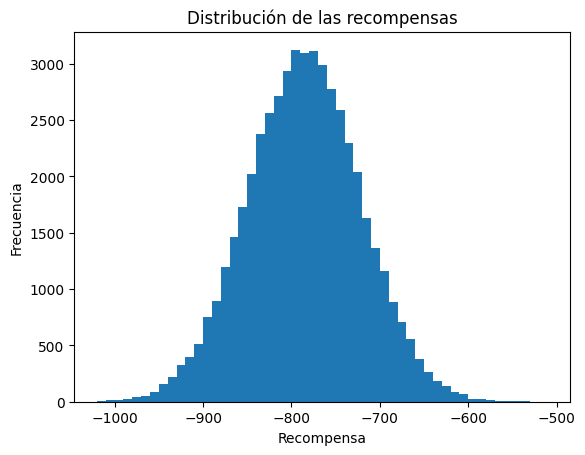

In [36]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards, bins=bins)
plt.title('Distribución de las recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.show()

In [37]:
class FireAutoencoder_reward(nn.Module):
    def __init__(self, capacity, input_size, latent_dims, sigmoid=False):
        super(FireAutoencoder_reward, self).__init__()
        self.c = capacity
        kernel_size = 4
        stride = 2
        padding = 1
        self.dim_1 = int((input_size - kernel_size + 2*padding)/2 + 1)
        self.dim_2 = int((self.dim_1 - kernel_size + 2*padding)/2 + 1)
        self.is_sigmoid = sigmoid
        # Encoder layers:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=kernel_size, stride=stride, padding=padding) # (64, 10, 10)
        self.conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=kernel_size, stride=stride, padding=padding) # (128, 5, 5)
        self.fc = nn.Linear(in_features=latent_dims*(self.dim_2**2), out_features = latent_dims)

        # Decoder layers:
        self.fc_2 = nn.Linear(in_features=latent_dims, out_features=latent_dims*(self.dim_2**2))
        self.conv1_2 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2_2 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding)
        if self.is_sigmoid:
            self.sigmoid = nn.Sigmoid()

        # Reward predictor:
        self.fc_r1 = nn.Linear(in_features=latent_dims, out_features=128)
        self.fc_r2 = nn.Linear(in_features=128, out_features=64)
        self.fc_r3 = nn.Linear(in_features=64, out_features=32)
        self.fc_r4 = nn.Linear(in_features=32, out_features=1)
        # Inicialización de parámetros:
        nn.init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

    def encode(self, x):
        u1 = F.relu(self.conv1(x))
        u2 = F.relu(self.conv2(u1))
        flat = u2.view(x.size(0), -1)
        output = self.fc(flat)
        return output

    
    def decode(self, x):
        h = self.fc_2(x)
        mat = h.view(x.size(0), self.c*2, self.dim_2, self.dim_2)
        u1 = F.relu(self.conv1_2(mat))
        u2 = self.sigmoid(self.conv2_2(u1)) if self.is_sigmoid else F.relu(self.conv2_2(u1))
        return u2
    
    def predict_reward(self, x):
        h1 = F.relu(self.fc_r1(x))
        h2 = F.relu(self.fc_r2(h1))
        h3 = F.relu(self.fc_r3(h2))
        reward = self.fc_r4(h3)
        return reward

    def forward(self, x):
        embedding = self.encode(x)
        return self.decode(embedding), self.predict_reward(embedding)

In [38]:
net = FireAutoencoder_reward(capacity, input_size, latent_dims, sigmoid=True)
criterion_1 = nn.BCELoss()
criterion_2 = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

In [39]:
net.is_sigmoid

True

In [40]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1113858


In [41]:
for z,y in train_loader:
    break

In [42]:
print(y.type())

torch.FloatTensor


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
epochs = 10
training_loss = []
validation_loss = []
reconstruction_training_loss = []
reconstruction_validation_loss = []
regression_training_loss = []
regression_validation_loss = []
for epoch in range(epochs):
    n = 0
    m = 0
    epoch_loss = 0
    val_epoch_loss = 0
    reconstruction_epoch_loss = 0
    val_reconstruction_epoch_loss = 0
    regression_epoch_loss = 0
    val_regression_epoch_loss = 0
    for x, r_x in train_loader:
        x = x.to(device)
        output, r = net(x)
        reconstruction_loss = criterion_1(output, x)
        regression_loss = criterion_2(r_x.unsqueeze(1), r)
        total_loss = reconstruction_loss + regression_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        reconstruction_epoch_loss += reconstruction_loss.item()
        regression_epoch_loss += regression_loss.item()
        n += 1
    
    for y, r_y in validation_loader:
        y = y.to(device)
        output, r = net(y)
        val_reconstruction_loss = criterion_1(output, y)
        val_regression_loss = criterion_2(r_y.unsqueeze(1), r)
        val_total_loss = val_reconstruction_loss + val_regression_loss
        val_epoch_loss += val_total_loss.item()
        val_reconstruction_epoch_loss += val_reconstruction_loss.item()
        val_regression_epoch_loss += val_regression_loss.item()
        m+=1
    reconstruction_training_loss.append(reconstruction_epoch_loss/n)
    reconstruction_validation_loss.append(val_reconstruction_epoch_loss/m)
    regression_training_loss.append(regression_epoch_loss/n)
    regression_validation_loss.append(val_regression_epoch_loss/m)
    training_loss.append(epoch_loss/n)
    validation_loss.append(val_epoch_loss/m)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, epoch_loss/n))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, epochs, val_epoch_loss/m))

Epoch [1/10], Loss: 58641.5885
Epoch [1/10], Validation Loss: 5164.4060
Epoch [2/10], Loss: 4479.0542
Epoch [2/10], Validation Loss: 4391.5210
Epoch [3/10], Loss: 3959.3162
Epoch [3/10], Validation Loss: 4115.7785
Epoch [4/10], Loss: 3749.3557
Epoch [4/10], Validation Loss: 3945.1256
Epoch [5/10], Loss: 3635.9183
Epoch [5/10], Validation Loss: 3838.0966
Epoch [6/10], Loss: 3563.2768
Epoch [6/10], Validation Loss: 3767.4974
Epoch [7/10], Loss: 3512.5612
Epoch [7/10], Validation Loss: 3719.9649
Epoch [8/10], Loss: 3475.4925
Epoch [8/10], Validation Loss: 3688.0748
Epoch [9/10], Loss: 3447.5508
Epoch [9/10], Validation Loss: 3666.8039
Epoch [10/10], Loss: 3425.7964
Epoch [10/10], Validation Loss: 3652.5707


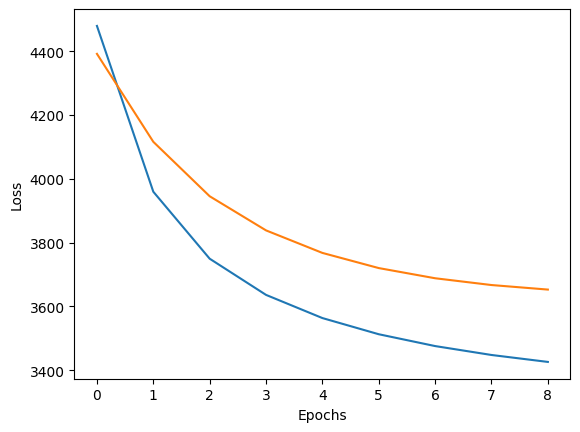

In [67]:
plt.ion()
fig = plt.figure()
plt.plot(training_loss[1:], label='training loss')
plt.plot(validation_loss[1:], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

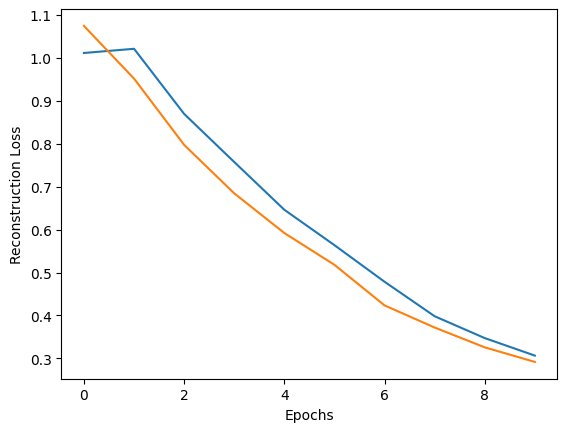

In [45]:
plt.ion()
fig = plt.figure()
plt.plot(reconstruction_training_loss, label='training loss'
)
plt.plot(reconstruction_validation_loss, label='validation loss'
)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.show()

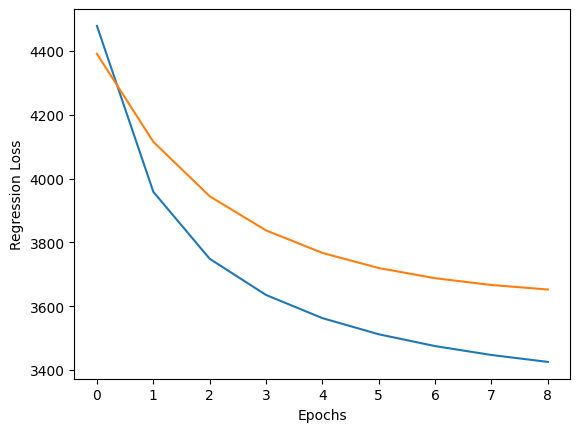

In [68]:
plt.ion()
fig = plt.figure()
plt.plot(regression_training_loss[1:], label='training loss'
)
plt.plot(regression_validation_loss[1:], label='validation loss'
)
plt.xlabel('Epochs')
plt.ylabel('Regression Loss')
plt.show()

Original images


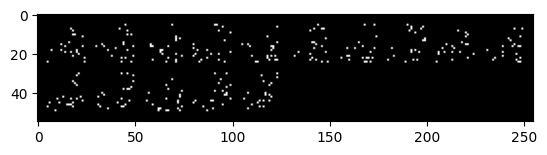

Autoencoder:


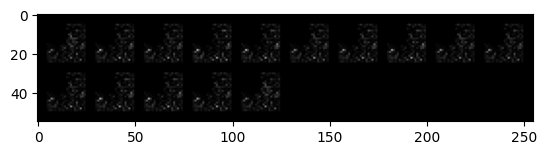

In [63]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, _ = next(iter(train_loader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('Autoencoder:')
visualise_output(images, net)

In [ ]:
path_ = f"./weights/homo_2_sub20x20_latent={latent_dims}_capacity={capacity}_sigmoid={sigmoid}.pth"
torch.save(net.state_dict(), path_)